# Finished Goods Inventory indicator for RACE

Indicator E8 is calculated at the logistic areas operated at the production sites such as motor vehicle manufacturing, the large number of metal objects (e.g. machinery, vehicles) produces a strong signature in the radar backscatter signal. The observations are provided by the Synthetic Aperture Radar such as the C-band Copernicus Sentinel-1 satellites (source: [RACE ESA](https://race.esa.int/?indicator=E8&poi=DE5-E8&country=DE))

## Importing needed modules

In [70]:
#imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [71]:
import datetime as dt
import os

from matplotlib import mlab
from shapely import geometry, wkt

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from datetime import datetime

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    Geometry,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    SHConfig,
    parse_time,
    geometry,
    SentinelHubCatalog,
    bbox_to_dimensions,
)

## SentinelHub account configuration

In [72]:
sh_client_id=""
sh_client_secret=""

if not sh_client_id:
    sh_client_id = os.environ["SH_CLIENT_ID"]

if not sh_client_secret:
    sh_client_secret = os.environ["SH_CLIENT_SECRET"]


if not sh_client_id or not sh_client_secret:
    raise ValueError("No valid Sentinel HUB credentials are available. Plese contact system administrator.")    
    
config = SHConfig()

config.sh_client_id = sh_client_id
config.sh_client_secret = sh_client_secret

#OUTPUT_DIR = os.path.join(USR_PATH, "output") #local folder


## Input Parameters
Volvo Cars, Ghent, Belgium


In [73]:
aoi = "POLYGON ((3.754824 51.096633, \
              3.753451 51.096242, \
              3.755747 51.093102, \
              3.755661 51.09511, \
              3.755211 51.094989, \
              3.754953 51.095393, \
              3.755211 51.09608, \
              3.755125 51.0967, \
              3.755447 51.097953, \
              3.755168 51.098048, \
              3.755009 51.097886, \
              3.754116 51.097697, \
              3.754824 51.096633))"

time_period= "2023-01-01/2023-05-31"

OUTPUT_DIR = "/home/jovyan/PLES_WORKSPACE/Anca_E8/result-data/e8" # will be copied to the local folder of the user requesting the data


### Parameter preparation

In [74]:
from_to = time_period.split("/")

interval = (f'{from_to[0]}T00:00:00Z', f'{from_to[1]}T23:59:59Z')
print(f'interval: {interval}')

geometry = Geometry(aoi, crs=CRS.WGS84)
print(geometry)

size = bbox_to_dimensions(geometry.bbox, resolution=5)
print(f'size: {size}')

collection = DataCollection.SENTINEL1_IW
print(f'collection: {collection}')

interval: ('2023-01-01T00:00:00Z', '2023-05-31T23:59:59Z')
Geometry(POLYGON ((3.754824 51.096633, 3.753451 51.096242, 3.755747 51.093102, 3.755661 51.09511, 3.755211 51.094989, 3.754953 51.095393, 3.755211 51.09608, 3.755125 51.0967, 3.755447 51.097953, 3.755168 51.098048, 3.755009 51.097886, 3.754116 51.097697, 3.754824 51.096633)), crs=CRS('4326'))
size: (31, 110)
collection: DataCollection.SENTINEL1_IW


## Evalscript definition
Evalscript to retreve the VH channel in linear units

In [75]:
#evalscript (linear units)
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["VH", "dataMask"]
    }],
    output: [
      {
        id: "default",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    return {
        default: [samples.VH],
        dataMask: [samples.dataMask],
    };
}

"""

## SentinelHub statistical API request (linear units)


In [76]:
# Definition of the SentinelHUB statistical API request (linear unit)
request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=interval,
        aggregation_interval='P1D', 
        size=size
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            collection,            
            other_args={"dataFilter": {"mosaickingOrder": "mostRecent","resolution": "HIGH"},
                        "processing": {"orthorectify": "True","backCoeff": "GAMMA0_TERRAIN","demInstance": "COPERNICUS"}},            
      ),
    ],
    geometry=geometry,
    config=config
)

In [77]:
# helper function

def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():

                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break
                band_name='gamma0'
                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

## Execute statistical API call

In [78]:
%%time

stats = request.get_data()[0]

CPU times: user 16.8 ms, sys: 2.73 ms, total: 19.5 ms
Wall time: 7.38 s


In [79]:
stats

{'data': [{'interval': {'from': '2023-01-02T00:00:00Z',
    'to': '2023-01-03T00:00:00Z'},
   'outputs': {'default': {'bands': {'B0': {'stats': {'min': 0.0,
        'max': 0.16340191662311554,
        'mean': 0.020170348377154566,
        'stDev': 0.022850378505722715,
        'sampleCount': 3410,
        'noDataCount': 2014}}}}}},
  {'interval': {'from': '2023-01-11T00:00:00Z', 'to': '2023-01-12T00:00:00Z'},
   'outputs': {'default': {'bands': {'B0': {'stats': {'min': 0.00053760054288432,
        'max': 0.24312031269073486,
        'mean': 0.04211890468930785,
        'stDev': 0.03629304571080026,
        'sampleCount': 3410,
        'noDataCount': 2014}}}}}},
  {'interval': {'from': '2023-01-14T00:00:00Z', 'to': '2023-01-15T00:00:00Z'},
   'outputs': {'default': {'bands': {'B0': {'stats': {'min': 0.0006729860324412584,
        'max': 0.19775378704071045,
        'mean': 0.031004727622934405,
        'stDev': 0.027735737722442297,
        'sampleCount': 3410,
        'noDataCount': 20

# Convert to Dataframe

In [80]:
#convert statistical data to pandas dataframe
df = stats_to_df(stats)
df=df[['interval_from','default_gamma0_mean']]
df.rename(columns = {'interval_from':'Acquisition date','default_gamma0_mean':'mean_gamma0'}, inplace = True)
df.head()

,Acquisition date,mean_gamma0
0,2023-01-02,0.020170
1,2023-01-11,0.042119
2,2023-01-14,0.031005
3,2023-01-23,0.037105
4,2023-01-26,0.014066


## Removing outliers

In [81]:
def remove_and_interpolate_outliers(df):
    import pandas as pd
    import numpy as np
    # Read stats file
    
    # create thresholds
    min_threshold, max_threshold = df['mean_gamma0'].quantile([0.01,0.99])
    
    # create a new dataframe excluding the outlier rows
    outlier_removed = df[(df['mean_gamma0'] < max_threshold)&(df['mean_gamma0'] > min_threshold)]
    outliersId = df[(df['mean_gamma0'] >= max_threshold) | (df['mean_gamma0'] <= min_threshold)].index
    
    # diplay the shape of new dataset
    print(outlier_removed.shape)
    # the orignal shape 
    print(df.shape)
    
    df2=df.copy()
    # fill with nans
    df2.loc[outliersId,['mean_gamma0']]=np.nan
    # interpolate nans
    outlier_rem_interp = df2.interpolate(method='nearest',order=2)
    return outlier_rem_interp


In [ ]:
df_filt=remove_and_interpolate_outlier(df)

## Exporting results

In [83]:
df.to_csv(os.path.join(OUTPUT_DIR,'average_gamma0_time_series.csv'),index=False)

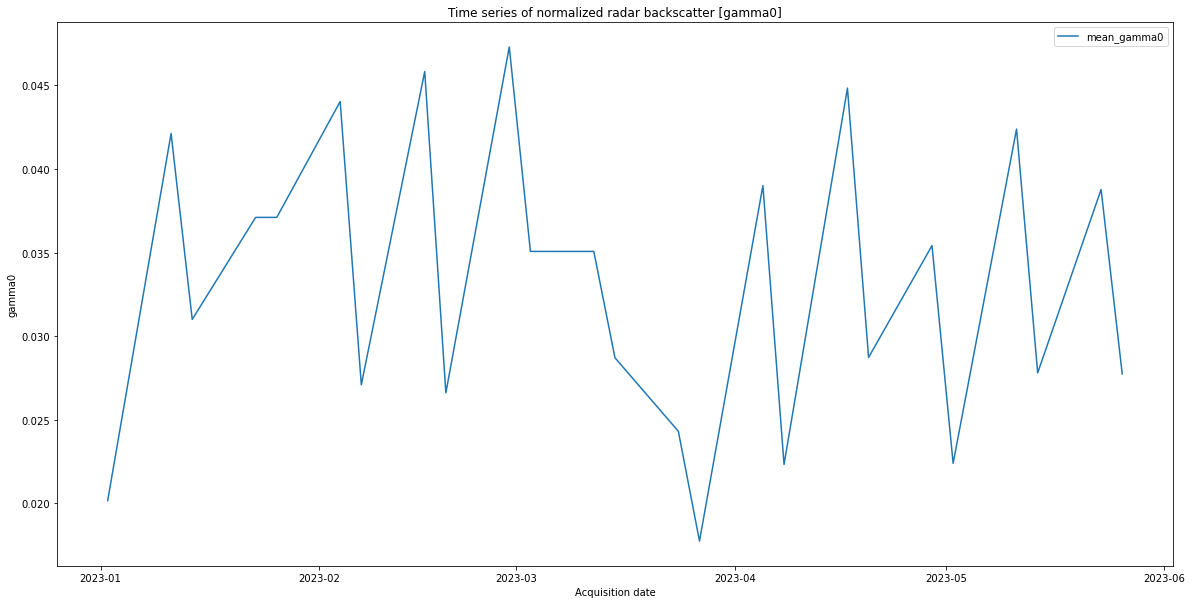

In [84]:
import matplotlib.pyplot as plt
import matplotlib

fig = df_filt.plot(x='Acquisition date', figsize=(20, 10), fontsize=10).get_figure()
plt.title('Time series of normalized radar backscatter [gamma0]')
plt.ylabel('gamma0')
fig.savefig(os.path.join(OUTPUT_DIR,'average_gamma0_time_series.pdf'))